In [294]:
import pandas as pd
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

<h1> Functions <h1>

In [ ]:
#logistic regression with RFE
def RFE_logistic(dataframe, y, n_features):
    logreg = LogisticRegression()
    y = y.astype(int)
    
    rfe = RFE(logreg, n_features_to_select=n_features)
    rfe = rfe.fit(dataframe, y)
    print(rfe.support_)
    print(rfe.ranking_)

In [ ]:
def fit_logistic (dataframe, y):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, y, test_size = 0.3)
    y_train = y_train.astype(int)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    print('Accuracy on test set: {:.2f}'.format (logreg.score(X_test, y_test)))
    plot_confusion_matrix(logreg, X_test, y_test)
    print(classification_report(y_test, y_pred))

In [ ]:
def knn_comparison(data, k):
    x = data[['radius_mean','texture_mean']].values
    y = data['prediction'].astype(int).values
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(x, y)
    #Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)
    #Adding axes annotations
    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.title('Knn with K='+ str(k))
    plt.show()

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

<h1> Loading dataset and EDA <h1>

In [ ]:
 df = pd.read_csv("/Users/dominik/Desktop/breast-cancer.csv")  
 df.head()

In [ ]:
df.dtypes


In [ ]:
df.describe()

In [ ]:
del df['id']

In [ ]:
df['diagnosis'].value_counts()

**we can see that whe have enough "malignant" labels, so we don't have to worry about not sufficient amount of the true labels**

In [ ]:
df.loc[df['diagnosis'] == 'M', 'diagnosis'] = 1
df.loc[df['diagnosis'] == 'B', 'diagnosis'] = 0

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
columns = df.columns[1:]

In [ ]:
for col in df.columns[1:]:
    
    fig = px.histogram(df[col], nbins = 60)
    fig.update_layout(bargap=0)
    fig.show()

In [ ]:
df_corr = df.corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
    z=np.array(df_corr),
    x=df_corr.index ,
    y=df_corr.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1
    )
)
fig.show()


In [ ]:
df.groupby('diagnosis').mean()

**This gives us a really clear view on which variables can matter while building a classification algorithm. For example, area_mean or concavity_mean seem to be really important, whereas fractal_dimension_mean or symmetry_mean have similar values for both labels**

In [ ]:
plot_data = df.iloc[:, 1:]


for col in df.columns[1:]:

    fig = px.histogram(
    df,
    x = "diagnosis",
    y = col,
    color = "diagnosis",
    histfunc = "avg"
    )
    fig.show()

**I've decided to create a classification model based on parameters describing mean values**

In [ ]:
df_model = [df[col] for col in df.columns if 'mean' in col]
df_model = pd.DataFrame(df_model).T
y = df['diagnosis']
df_model.head()

<h1> Configurating classification algorithms <h1>

<h2> I will try to fit 3 logistic regression models: <h2>
<h3>
1. Model with all variables from df_model dataframe <br>
2. 2 RFE models, which builds multiple models and checks if adding an additional variables makes the model better (will select 6 and 8 features) 
<h3>


In [ ]:
smlog = sm.Logit(y, sm.add_constant(df_model))
results = smlog.fit()
print(results.summary2())

In [ ]:
probability = 1 / (1 + np.exp(-results.fittedvalues))
px.histogram(probability)

In [ ]:
fit_logistic(df_model, y)

**Second model (RFE with 8 features)**

In [ ]:
df_model2 = df_model.copy()

In [ ]:
RFE_logistic(df_model2, y, 8)

In [ ]:
df_model2 = df_model2.drop(['area_mean', 'fractal_dimension_mean'], axis = 1)

In [ ]:
smlog = sm.Logit(y, sm.add_constant(df_model2))
results = smlog.fit()
print(results.summary2())

In [ ]:
probability = 1 / (1 + np.exp(-results.fittedvalues))
px.histogram(probability)

In [ ]:
fit_logistic(df_model2, y)

**Third model: RFE Logistic with 5 features**

In [ ]:
df_model3 = df_model.copy()

In [ ]:
RFE_logistic(df_model3, y, 5)

In [ ]:
df_model3 = df_model3.drop(['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'fractal_dimension_mean'], axis = 1)

In [ ]:
smlog_3 = sm.Logit(y, sm.add_constant(df_model3))
results = smlog_3.fit()
print(results.summary2())

In [ ]:
probability = 1 / (1 + np.exp(-results.fittedvalues))
px.histogram(probability)

In [ ]:
fit_logistic(df_model3, y)

<h2> Using SVM <h2>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model, y, test_size = 0.3, random_state = 0)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
plot_confusion_matrix(svm, X_test_scaled, y_test)
print("Accuracy on test set: {}".format(svm.score(X_test_scaled, y_test)))

In [ ]:
print(classification_report(y_test, y_pred))

**As we can see, SVM perform better. It is more often chosen when it comes to handling little datasets. Let's find out if we can somehow optimize the parameters by executing Cross Validation (GridSearchCV)**

In [ ]:
initial_gamma = ['scale']
additional_gammas = np.arange(0, 1, 0.01)
additional_gammas = additional_gammas.tolist()
gammas = initial_gamma + additional_gammas

param_grid = [
    {'C': np.arange(1, 100, 1),
    'gamma': gammas,
    'kernel': ['rbf']}
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 2
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

**It seems like C = 81, gamma = 0.02 are the optimal values of parameters, let's fit a final SVM model**

In [ ]:
reg_svm = SVC(C = 81, gamma = 0.02)
reg_svm.fit(X_train_scaled, y_train)
plot_confusion_matrix(reg_svm, X_test_scaled, y_test)

In [ ]:
y_pred = reg_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

**We were able to achieve better performance of the model with a regularization**

**Now let's try other classification algorithms (KNN, Decision Tree Classification, Random Forest)**

<h2> KNN <h2>

In [ ]:
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
for neighbor in n_neighbors:
     knn = KNeighborsClassifier(n_neighbors = neighbor)
     knn.fit(X_train_scaled, y_train)
     y_pred = knn.predict(X_test_scaled)
     print('For the number of neighbors {:.2f}'.format(neighbor) + ' accuracy = {:.2f}'.format(knn.score(X_test_scaled, y_test)))

**The smallest number of neighbors giving the best predictions is 6, let's take a closer look at this configuration**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

plot_confusion_matrix(knn, X_test_scaled, y_test)
print(classification_report(y_test, y_pred))

**Once again we've found a better performance than logistic regression, however, a little bit worse than SVM. Let's try to visualize the Test Set results**

In [ ]:
df_visualize = X_test_scaled.copy()
df_visualize = pd.DataFrame(df_visualize)
df_visualize.columns = X_test.columns
df_visualize ['prediction'] = y_pred
sns.relplot(x = 'radius_mean', y = 'texture_mean', hue = 'prediction', data = df_visualize)

**As we can see - larger mean of the tumor radius and texture leads to the positive prediction of the cancer 
Let's find out how the decision surface looks like for these two characteristics for differenct configurations of the number of neighbors.**

In [ ]:
for i in [1, 5, 6, 20, 30, 40, 80]:
    knn_comparison(df_visualize, i)

**Let's try to fit the first decision tree to our training data**

<h2> Decision tree <h2>

In [ ]:
clf_dt = DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train, y_train)

**Let's see how our first tree looks like**

In [ ]:
fig = plt.figure(figsize = (150,120))
_ = tree.plot_tree(clf_dt, feature_names = X_train.columns, class_names = ["No cancer", "Cancer"], filled = True)

In [ ]:
plot_confusion_matrix(clf_dt, X_test, y_test)
y_pred = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred))

**We can clearly see that our classification tree overfits the data. Moreover, the tree is really huge and maybe we can make it smaller. Let's try to execute data pruning**

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [ ]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy depending on the alpha parameter: training vs. testing')
ax.plot(ccp_alphas, train_scores, marker = 'o', label = 'train', drawstyle = 'steps-post')
ax.plot(ccp_alphas, test_scores, marker = 'o', label = 'test', drawstyle = 'steps-post')
ax.legend()
plt.show


**We can see that our optimal value of alpha is somewhere between 0 and 0.005**

**we may assume that our "best" tree performed this good only on one specific type of the training data, a good idea is to perform cross validation with every value of alpha and check which configuration has the largest mean of the accuracy**

In [ ]:
statistics = []
best_score = 0
best_alpha = 0
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 10)
    statistics.append([ccp_alpha, np.mean(scores), np.std(scores)])
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_alpha = ccp_alpha

print("best alpha value: {}".format(best_alpha))

In [ ]:
cv_results = pd.DataFrame(statistics, columns = ['alpha_value', 'mean_accuracy', 'standard_deviation'])
cv_results.plot(x = 'alpha_value', y = 'mean_accuracy', yerr = 'standard_deviation', marker = 'o')

**Let's see our final model**

In [ ]:
clf_dt = DecisionTreeClassifier(ccp_alpha = 0.00326737)
clf_dt.fit(X_train, y_train)
plot_confusion_matrix(clf_dt, X_test, y_test)

y_pred = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred))

**And the final tree**

In [ ]:
fig = plt.figure(figsize = (100,80))
_ = tree.plot_tree(clf_dt, feature_names = X_train.columns, class_names = ["No cancer", "Cancer"], filled = True)

**By performing cross validation and tree pruning we were able to achieve higher accuracy and construct a simpler tree.**

<h2> Random Forest <h2>

**Let's see what is the optimal value for the number of trees**

In [295]:
num_trees = [20, 40, 60, 80, 100, 120, 140]
configurations = []
for trees in num_trees:
    performance_train = []
    performance_test = []
    
    for i in range(10):
        model = RandomForestClassifier(n_estimators = trees, oob_score=True)
        model.fit(df_model, y)
    
        score_train = model.score(df_model, y)
        score_test = model.oob_score_
        performance_train.append(score_train)
        performance_test.append(score_test)

    configurations.append([trees, np.mean(performance_train), np.mean(performance_test)])
    print("For the number of trees: {}, traininig accuracy = {}, testing accuracy= {}".format(trees, np.mean(performance_train), np.mean(performance_test)))

For the number of trees: 20, traininig accuracy = 0.9985940246045695, testing accuracy= 0.9344463971880492
For the number of trees: 40, traininig accuracy = 0.9989455184534272, testing accuracy= 0.9400702987697717
For the number of trees: 60, traininig accuracy = 1.0, testing accuracy= 0.9416520210896309
For the number of trees: 80, traininig accuracy = 1.0, testing accuracy= 0.9418277680140597
For the number of trees: 100, traininig accuracy = 1.0, testing accuracy= 0.9427065026362037
For the number of trees: 120, traininig accuracy = 1.0, testing accuracy= 0.9420035149384883
For the number of trees: 140, traininig accuracy = 1.0, testing accuracy= 0.9404217926186291


**It seems like the number of trees = 100 is an optimal value. Let's fit a final model and check the importance of the features**

In [296]:
feature_names = df_model.columns

forest = RandomForestClassifier()
forest.fit(df_model, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

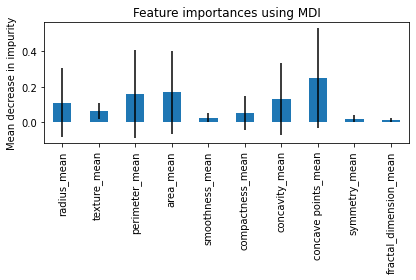

In [297]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


**We can observe that some of the features (smoothness_mean, symmetry_mean, fractal_dimension_mean) are not that useful while building a Random Forest model.**